In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
grouped = pd.read_csv('../tensorMaker/groupedTop200.csv')
meta = pd.read_csv("../tensorMaker/nftMetaData.csv")

In [3]:
grouped['timeStamp'] = pd.to_datetime(grouped['timeStamp'], utc=True)
grouped["timeStamp-day"] = grouped['timeStamp'].dt.floor('D')
grouped["nft_address"] = grouped["nft_address"].str.lower()

In [4]:
from scipy.stats import kurtosis
pivot_trades = pd.pivot_table(grouped, values="quant", index="timeStamp-day", columns="nft_address", aggfunc=np.sum)
pivot_mean = pd.pivot_table(grouped, values="priceInDollar", index="timeStamp-day", columns="nft_address", aggfunc=np.mean)
pivot_mean_log = pd.pivot_table(grouped, values="priceInDollarLog", index="timeStamp-day", columns="nft_address", aggfunc=np.mean)
pivot_max_log = pd.pivot_table(grouped, values="priceInDollarLog", index="timeStamp-day", columns="nft_address", aggfunc=np.max)
pivot_std_log = pd.pivot_table(grouped, values="priceInDollarLog", index="timeStamp-day", columns="nft_address", aggfunc=np.std)
pivot_var_log = pd.pivot_table(grouped, values="priceInDollarLog", index="timeStamp-day", columns="nft_address", aggfunc=np.var)
pivot_change_in_trades = pd.pivot_table(grouped, values="quant", index="timeStamp-day", columns="nft_address", aggfunc=np.sum).rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])
pivot_change_in_log_prices = pd.pivot_table(grouped, values="priceInDollarLog", index="timeStamp-day", columns="nft_address", aggfunc=np.mean).rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])
pivot_kurt_log = pd.pivot_table(grouped, values="priceInDollarLog", index="timeStamp-day", columns="nft_address", aggfunc=kurtosis)

In [5]:
tensor = np.array([
    pivot_trades,
    pivot_mean,
    pivot_mean_log,
    pivot_max_log,
    pivot_std_log,
    pivot_var_log,
    pivot_change_in_trades,
    pivot_change_in_log_prices,
    pivot_kurt_log
])

In [6]:
import numpy as np
import pandas as pd
from scipy.stats import kurtosis
clusterDataList = []

for series in range(tensor.shape[2]):
    clusterData = {}
    
    data = tensor[:,:, series]

    clusterData['nft']=pivot_trades.iloc[:,series].name
    clusterData['Length']=len(data[0,:][~np.isnan(data[0,:])])

    clusterData['changeSquared_trade']=np.mean(np.power(data[6,:][~np.isnan(data[6,:])],2))
    
    clusterData['changeSquared_price']=np.mean(np.power(data[7,:][~np.isnan(data[7,:])],2))
    clusterData['changeCube_price']=np.mean(np.power(data[7,:][~np.isnan(data[7,:])],3))
    
    clusterData['changeSquared_price_log'] = np.log10(clusterData['changeSquared_price'])
    clusterData['changeCube_price_log'] = np.log10(clusterData['changeSquared_price'])

    for statisticsSeries in range(tensor.shape[0]):
        clusterData[statisticsSeries,'average'] =np.average(data[statisticsSeries,:][~np.isnan(data[statisticsSeries,:])])
        clusterData[statisticsSeries,'median'] =np.nanmedian(data[statisticsSeries,:])
        clusterData[statisticsSeries,'var'] =np.nanvar(data[statisticsSeries,:])
        clusterData[statisticsSeries,'mean'] = np.nanmean(data[statisticsSeries,:])
        clusterData[statisticsSeries,'std'] =np.nanstd(data[statisticsSeries,:])
        clusterData[statisticsSeries,'max'] =np.max(data[statisticsSeries,:][~np.isnan(data[statisticsSeries,:])])
        clusterData[statisticsSeries,'min'] =np.min(data[statisticsSeries,:][~np.isnan(data[statisticsSeries,:])])
        clusterData[statisticsSeries,'sum'] =np.sum(data[statisticsSeries,:][~np.isnan(data[statisticsSeries,:])])
        clusterData[statisticsSeries,'kurtosis'] = kurtosis(data[statisticsSeries,:][~np.isnan(data[statisticsSeries,:])])
    
    clusterDataList.append(clusterData)

x = pd.DataFrame(clusterDataList)

In [7]:
x = pd.merge(x, meta, on="nft")

In [8]:
x.iloc[:2,1:]

,Length,changeSquared_trade,changeSquared_price,changeCube_price,changeSquared_price_log,changeCube_price_log,"(0, average)","(0, median)","(0, var)","(0, mean)",...,"(8, sum)","(8, kurtosis)",uniqueTokens,uniqueTransactions,uniqueSellers,uniqueBuyers,uniqueMints,stdTransactionsPerToken,meanTransactionsPerToken,varTransactionsPerToken
0,83,49517.609756,0.122242,0.009615,-0.912779,-0.912779,100.421687,32.0,70743.858325,100.421687,...,205.231141,3.185919,5628,7800,2084,3297,0,0.749451,1.481699,0.561676
1,88,18994.436782,0.331230,-0.025410,-0.479871,-0.479871,116.750000,63.0,30298.528409,116.750000,...,123.269242,0.213143,3426,4417,2015,2210,0,0.677868,1.383830,0.459505


In [9]:
correlation = x.iloc[:,1:].corr()
correlation.style.background_gradient(cmap='coolwarm')

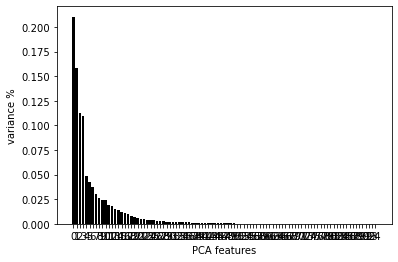

In [10]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

X = x.iloc[:,1:]
X_std = StandardScaler().fit_transform(X)

pca = PCA()
principalComponents = pca.fit_transform(X_std)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

PCA_components = pd.DataFrame(principalComponents)

In [11]:
tSNE = TSNE(n_components=2)
tSNE_COMPS = tSNE.fit_transform(PCA_components)

tSNE_PCA_components = pd.DataFrame(tSNE_COMPS)

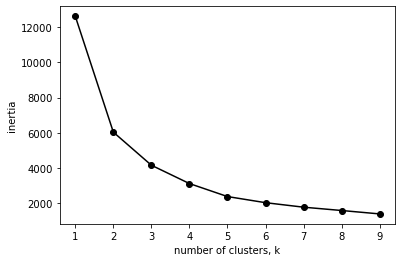

In [12]:
ks = range(1, 10)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(tSNE_PCA_components)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

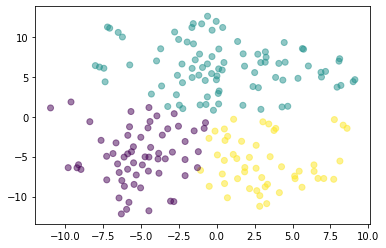

In [13]:
kmeanstSNE = KMeans(n_clusters=3)
labels = kmeanstSNE.fit_predict(tSNE_COMPS)

plt.scatter(tSNE_PCA_components[0], tSNE_PCA_components[1], c=labels, alpha=.5)
plt.show()


# from mpl_toolkits.mplot3d import Axes3D

# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.scatter3D(tSNE_PCA_components[0], tSNE_PCA_components[1], tSNE_PCA_components[2], c=labels, alpha=.9)
# ax.view_init(elev=20., azim=200)

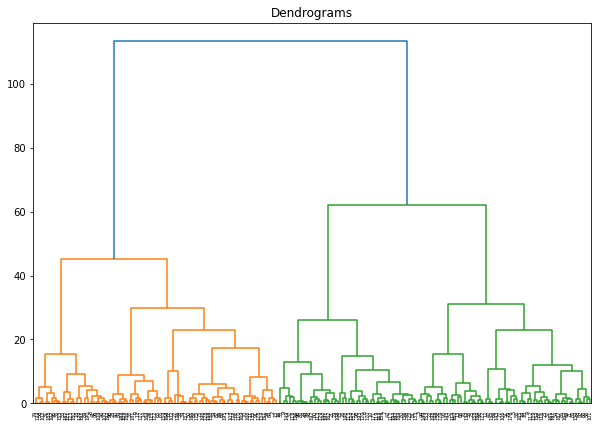

In [14]:
# Dendogram for Heirarchical Clustering
import scipy.cluster.hierarchy as shc
from matplotlib import pyplot
pyplot.figure(figsize=(10, 7))  
pyplot.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(tSNE_PCA_components, method='ward'))

In [15]:
x["labels-tSNE_PCA"] = labels

In [16]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

X = x.iloc[:,1:]
X_std = StandardScaler().fit_transform(X)

tSNE = TSNE(n_components=2)
tSNE_COMPS = tSNE.fit_transform(X_std)

tSNE_components = pd.DataFrame(tSNE_COMPS)

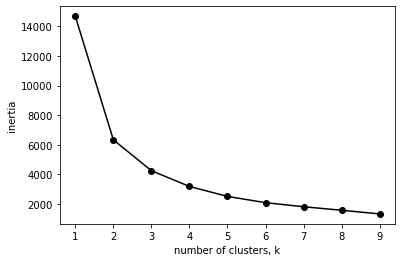

In [17]:
from sklearn.cluster import KMeans

ks = range(1, 10)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(tSNE_components)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

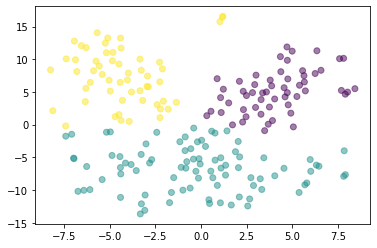

In [18]:
kmeanstSNE = KMeans(n_clusters=3)
labels = kmeanstSNE.fit_predict(tSNE_components)
plt.scatter(tSNE_components[0], tSNE_components[1], c=labels, alpha=.5)
plt.show()

In [19]:
x["labels-tSNE"] = labels

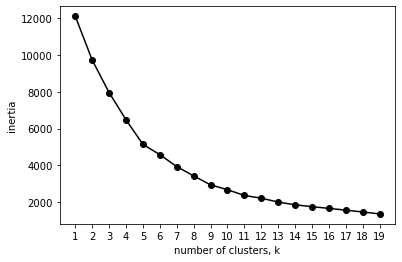

In [20]:
from sklearn.cluster import KMeans

ks = range(1, 20)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:5])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

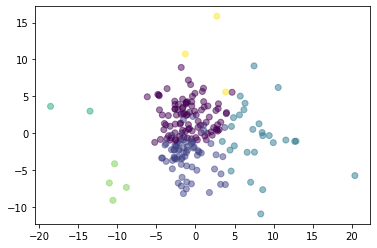

In [21]:
kmeansPCA = KMeans(n_clusters=6)
labels = kmeansPCA.fit_predict (PCA_components.iloc[:,:5])
plt.scatter(PCA_components[0], PCA_components[1], c=labels, alpha=.5)
plt.show()

In [22]:
# from mpl_toolkits.mplot3d import Axes3D

# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.scatter3D(PCA_components[0], PCA_components[1], PCA_components[4], c=labels, alpha=.9)
# ax.view_init(elev=20., azim=100)

In [23]:
x["labels_5f-6c"] = labels

In [24]:
nftAddressNames = pd.read_csv("../webscraper/nftNames-baseline.csv")

nftNames = dict(zip(nftAddressNames["addressBaselined"], nftAddressNames["name"]))
nftSymbol = dict(zip(nftAddressNames["addressBaselined"], nftAddressNames["symbol"]))

In [25]:
nftAddressNames[nftAddressNames["address"]=="0x7cba74d0b16c8e18a9e48d3b7404d7739bb24f23"]

,address,name,symbol,addressBaselined


In [26]:
x["name"] = x["nft"].replace(nftNames)
x["symbol"] = x["nft"].replace(nftSymbol)

In [27]:
x[x["nft"]=="0x7cba74d0b16c8e18a9e48d3b7404d7739bb24f23"]

,nft,Length,changeSquared_trade,changeSquared_price,changeCube_price,changeSquared_price_log,changeCube_price_log,"(0, average)","(0, median)","(0, var)",...,uniqueBuyers,uniqueMints,stdTransactionsPerToken,meanTransactionsPerToken,varTransactionsPerToken,labels-tSNE_PCA,labels-tSNE,labels_5f-6c,name,symbol
96,0x7cba74d0b16c8e18a9e48d3b7404d7739bb24f23,12,444978.636364,0.037771,0.001774,-1.42284,-1.42284,777.5,578.0,416536.583333,...,4550,9962,0.908315,1.973499,0.825036,0,0,0,0x7cba74d0b16c8e18a9e48d3b7404d7739bb24f23,0x7cba74d0b16c8e18a9e48d3b7404d7739bb24f23


In [28]:
x[x["labels-tSNE_PCA"]==1].head(10)

,nft,Length,changeSquared_trade,changeSquared_price,changeCube_price,changeSquared_price_log,changeCube_price_log,"(0, average)","(0, median)","(0, var)",...,uniqueBuyers,uniqueMints,stdTransactionsPerToken,meanTransactionsPerToken,varTransactionsPerToken,labels-tSNE_PCA,labels-tSNE,labels_5f-6c,name,symbol
0,0x004f5683e183908d0f6b688239e3e2d5bbb066ca,83,4.951761e+04,0.122242,0.009615,-0.912779,-0.912779,100.421687,32.0,7.074386e+04,...,3297,0,0.749451,1.481699,0.561676,1,1,0,Hall Of Fame Goat Lodge,HOFG
1,0x02aa731631c6d7f8241d74f906f5b51724ab98f8,88,1.899444e+04,0.331230,-0.025410,-0.479871,-0.479871,116.750000,63.0,3.029853e+04,...,2210,0,0.677868,1.383830,0.459505,1,1,1,Bears,BEAR
2,0x0429ca1e4c690f10606b8c85e4dc6b7e54e9ad30,22,1.439754e+06,0.181782,0.066465,-0.740450,-0.740450,511.318182,203.0,8.024478e+05,...,10,23,0.000000,1.000000,0.000000,1,1,1,Sipher INU,INU
5,0x06012c8cf97bead5deae237070f9587f8e7a266d,178,5.115899e+04,0.063966,-0.004880,-1.194051,-1.194051,386.662921,340.0,5.864576e+04,...,14813,290,0.857079,1.400594,0.734584,1,1,0,暗号漢字-CryptoKanji-,CK
8,0x099689220846644f87d1137665cded7bf3422747,75,1.066488e+05,0.118483,0.017012,-0.926345,-0.926345,279.106667,142.0,2.184199e+05,...,9601,0,1.451472,2.415544,2.106770,1,1,0,Robots,ROBO
11,0x0e3a2a1f2146d86a604adc220b4967a898d7fe07,150,1.346937e+04,0.490095,-0.107408,-0.309720,-0.309720,85.753333,21.5,2.321472e+04,...,696,0,0.659679,1.684521,0.435177,1,1,1,Cards Against NFTs,CARD
14,0x14f03368b43e3a3d27d45f84fabd61cc07ea5da3,106,1.358467e+04,0.162598,0.026913,-0.788886,-0.788886,105.443396,53.0,2.807779e+04,...,3127,0,0.848151,1.541207,0.719360,1,1,0,LuckyManekiNFT,LMK
15,0x157b9d66f864b2c2b8228efd4ad92b38410e4fa6,44,3.163119e+06,0.363840,-0.117249,-0.439089,-0.439089,457.704545,17.5,2.353721e+06,...,31,0,0.110423,1.012346,0.012193,1,1,1,Digital Dinos,DINO
17,0x18765ee2ab5d2ab4adf27f4209cb25b89372d61d,91,8.497057e+03,0.057204,0.000836,-1.242575,-1.242575,99.615385,57.0,1.736395e+04,...,86,11,0.111447,1.012579,0.012420,1,1,0,BlackBox Colours,BBC
18,0x1897d69cc0088d89c1e94889fbd2efffcefed778,40,3.433916e+05,0.550905,-0.403829,-0.258923,-0.258923,253.075000,91.5,3.551844e+05,...,2677,457,0.974235,1.847416,0.949134,1,1,1,GamePass,GPASS


In [29]:
x.to_csv('clusters-top200.csv')

In [74]:
x.iloc[:,28]

0      1.901470
1      1.825183
2      1.969395
3      1.795174
4      1.213240
         ...   
194    2.170355
195    1.516348
196    1.591585
197    2.564570
198    1.832852
Name: (2, mean), Length: 199, dtype: float64

In [78]:
import scipy.stats as scStat

clusters = len(x["labels-tSNE_PCA"].unique())

print("")

for i in range(clusters):
    normality_priceStab = scStat.normaltest(x[x["labels-tSNE_PCA"]==i]["changeSquared_price"])
    print("Normality change price",normality_priceStab)
    print("mean change price",np.mean(x[x["labels-tSNE_PCA"]==i]["changeSquared_price"]))
    print("")

    normality_priceStab = scStat.normaltest(x[x["labels-tSNE_PCA"]==i]["changeSquared_trade"])
    print("Normality changetrade",normality_priceStab)
    print("")

    normality_priceStab = scStat.normaltest(x[x["labels-tSNE_PCA"]==i].iloc[:,28])
    print("Normality meanlog price",normality_priceStab)
    print("")


    print("mean change trade",np.mean(x[x["labels-tSNE_PCA"]==i]["changeSquared_trade"]))
    print("mean quant trade",np.mean(x[x["labels-tSNE_PCA"]==i].iloc[:,10]))
    print("")

    for z in range(clusters):
        tTest = 0
        if i != z: 
            tTest = scStat.ttest_ind(x[x["labels-tSNE_PCA"]==i]["changeSquared_price"],x[x["labels-tSNE_PCA"]==z]["changeSquared_price"])
            print("Compare cluster change price", i, " against:", z, ":", tTest)

            tTest = scStat.ttest_ind(x[x["labels-tSNE_PCA"]==i]["changeSquared_trade"],x[x["labels-tSNE_PCA"]==z]["changeSquared_trade"])
            print("Compare cluster change in trade", i, " against:", z, ":", tTest)

            tTest = scStat.ttest_ind(x[x["labels-tSNE_PCA"]==i].iloc[:,10],x[x["labels-tSNE_PCA"]==z].iloc[:,10])
            print("Compare cluster quantity trade", i, " against:", z, ":", tTest)

            tTest = scStat.ttest_ind(x[x["labels-tSNE_PCA"]==i].iloc[:,28],x[x["labels-tSNE_PCA"]==z].iloc[:,28])
            print("Compare cluster mean log price", i, " against:", z, ":", tTest)
    print("")


    # # the histogram of the data
    # n, bins, patches = plt.hist(np.log10(x[x["labels-tSNE_PCA"]==i]["changeSquared_price"]))
    # # n, bins, patches = plt.hist(x[x["labels-tSNE_PCA"]==i]["changeSquared_price"], density=True, facecolor='g', alpha=0.75)

    # plt.grid(True)
    # plt.show()


Normality change price NormaltestResult(statistic=82.23724570443895, pvalue=1.388062405312013e-18)
mean change price 0.11924656860695469

Normality changetrade NormaltestResult(statistic=128.72238020366441, pvalue=1.1176100283150036e-28)

Normality meanlog price NormaltestResult(statistic=10.766409584413426, pvalue=0.004593078455686176)

mean change trade 1478210.4293173638
mean quant trade 636.0480728065897

Compare cluster change price 0  against: 1 : Ttest_indResult(statistic=-6.668947576461928, pvalue=4.875217177848408e-10)
Compare cluster change in trade 0  against: 1 : Ttest_indResult(statistic=1.8493852272190547, pvalue=0.06641048566437212)
Compare cluster quantity trade 0  against: 1 : Ttest_indResult(statistic=4.1604498875129154, pvalue=5.381509122372563e-05)
Compare cluster mean log price 0  against: 1 : Ttest_indResult(statistic=6.915733181659107, pvalue=1.3259840856405865e-10)
Compare cluster change price 0  against: 2 : Ttest_indResult(statistic=-5.005988700430196, pvalue